In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.insert(0, '..')

In [3]:

import glob
import math

import seaborn
import pandas
from matplotlib import pyplot as plt

from src.experiments.analyze import enrich_results, plot_size_improvement, name_strategies


In [4]:
def read_parquet(pattern, **kwargs):
    frames = []
    for file in glob.glob(pattern):
        part = pandas.read_parquet(file, **kwargs)
        frames.append(part)

    df = pandas.concat(frames)
    return df
    

In [69]:
ref = read_parquet('../output/results/trees_min_samples_leaf_2/*sklearn*')
ref['min_samples_leaf'] = 1
ref['trees'] = 100
#ref = ref[ref.split <5 ]

hyper = read_parquet('../output/results/int16/*trees*')
#hyper = read_parquet('../output/results/max_depth/*trees*')
hyper['trees'] = hyper.n_estimators
data = pandas.concat([ref, hyper], ignore_index=True)
data = enrich_results(data, leaf_node_bytes_default=4)
#data['total_size_kb'] = data.total_size / 1000
data['leaf_size_percent'] = 100.0 * (data['leaf_size'] / data['total_size'])
data['unique_leaves_percent'] = 100.0 * (data['test_uniqueleaves'] / data['test_leaves'])
data = data[~data.dataset.isin(['1510'])]
data.head(5)

,leaves_per_class,leaf_bits,split,test_nodes,test_leaves,test_leafsize,test_uniqueleaves,test_roc_auc,dataset,experiment,...,n_estimators,dtype,target_max,folds,repetitions,leaf_size,decision_size,total_size,leaf_size_percent,unique_leaves_percent
id,,,,,,,,,,,,,,,,,,,,,
8d36ec7d-d35e-4e7c-864a-ff45215f7fcc,NaN,NaN,0,5092,2596,2.0,2,100.0,1462,sklearn_defaults,...,NaN,NaN,NaN,NaN,NaN,16.0,19968,19984.0,0.080064,0.077042
f49d43d0-412d-4322-a349-7bf7272583f7,1.0,NaN,0,5092,2596,2.0,2,100.0,1462,sklearn_defaults,...,NaN,NaN,NaN,NaN,NaN,16.0,19968,19984.0,0.080064,0.077042
c349bade-3206-46e3-bdc1-db20e75a9ec5,2.0,NaN,0,5092,2596,2.0,2,100.0,1462,sklearn_defaults,...,NaN,NaN,NaN,NaN,NaN,16.0,19968,19984.0,0.080064,0.077042
67662376-6c86-4da5-be10-e9647b602a50,4.0,NaN,0,5092,2596,2.0,2,100.0,1462,sklearn_defaults,...,NaN,NaN,NaN,NaN,NaN,16.0,19968,19984.0,0.080064,0.077042
22825ed5-1047-4b53-970d-7f357aae7789,8.0,NaN,0,5092,2596,2.0,2,100.0,1462,sklearn_defaults,...,NaN,NaN,NaN,NaN,NaN,16.0,19968,19984.0,0.080064,0.077042


In [70]:

def compute_perf_change(df, groupby='dataset', metric='test_roc_auc'):
    df = df.copy()

    ref_df = df[df.experiment == 'sklearn_defaults'].reset_index().groupby('dataset').median(numeric_only=True)

    print(sorted(ref_df.index))
    
    # Extract change in performance
    def subtract_ref(df, metric='test_roc_auc'):
        dataset = df.name
        matches = ref_df.loc[dataset]
        #assert len(matches) == 1, matches
        ref = matches[metric]
        out = df[metric] - ref
        return out

    def divide_ref(df, metric='test_roc_auc'):
        dataset = df.name
        matches = ref_df.loc[dataset]
        #assert len(matches) == 1, matches
        ref = matches[metric]
        out = df[metric] / ref
        return out

    grouped = df.groupby('dataset', as_index=False)
    df['perf_change'] = grouped.apply(subtract_ref, include_groups=False).reset_index().set_index('id')[metric]
    df['size_change'] = grouped.apply(divide_ref, metric='total_size', include_groups=False).reset_index().set_index('id')['total_size']

    return df

from src.experiments.analyze import name_strategies

unoptimized = name_strategies(data)
unoptimized = unoptimized[unoptimized.strategy.isin(['majority', 'original', 'joint'])]
unoptimized.loc[(unoptimized.experiment == 'sklearn_defaults') & (unoptimized.strategy != 'original')] = None
unoptimized.loc[(unoptimized.strategy == 'joint') & (unoptimized.leaf_bits != 4), 'strategy'] = None
#unoptimized.loc[(unoptimized.strategy == 'joint') & (unoptimized.leaves_per_class != 8), 'strategy'] = None
unoptimized = unoptimized.dropna(subset=['strategy'])
#print(unoptimized[unoptimized.experiment == 'sklearn_defaults']['strategy'].value_counts())
print(unoptimized.experiment.value_counts())
print(unoptimized.strategy.value_counts())
unoptimized = compute_perf_change(unoptimized, groupby=['dataset'])
unoptimized.head(1)

#unoptimized.experiment.value_counts()

experiment
trees_minsamplesleaf_int16-20-2      2040
trees_minsamplesleaf_int16-20-64     2040
trees_minsamplesleaf_int16-10-64     2040
trees_minsamplesleaf_int16-5-4       2040
trees_minsamplesleaf_int16-20-128    2040
trees_minsamplesleaf_int16-5-8       2040
trees_minsamplesleaf_int16-40-1      2040
trees_minsamplesleaf_int16-10-32     2040
trees_minsamplesleaf_int16-5-2       2040
trees_minsamplesleaf_int16-5-1       2040
trees_minsamplesleaf_int16-5-128     2040
trees_minsamplesleaf_int16-5-16      2040
trees_minsamplesleaf_int16-40-64     2040
trees_minsamplesleaf_int16-10-128    2040
trees_minsamplesleaf_int16-40-16     2040
trees_minsamplesleaf_int16-40-8      2040
trees_minsamplesleaf_int16-40-32     2040
trees_minsamplesleaf_int16-20-4      2040
trees_minsamplesleaf_int16-10-4      2040
trees_minsamplesleaf_int16-10-2      2040
trees_minsamplesleaf_int16-5-32      2040
trees_minsamplesleaf_int16-20-16     2040
trees_minsamplesleaf_int16-5-64      2040
trees_minsamplesleaf_in

,leaves_per_class,leaf_bits,split,test_nodes,test_leaves,test_leafsize,test_uniqueleaves,test_roc_auc,dataset,experiment,...,folds,repetitions,leaf_size,decision_size,total_size,leaf_size_percent,unique_leaves_percent,strategy,perf_change,size_change
id,,,,,,,,,,,,,,,,,,,,,
8d36ec7d-d35e-4e7c-864a-ff45215f7fcc,NaN,NaN,0.0,5092.0,2596.0,2.0,2.0,100.0,1462,sklearn_defaults,...,NaN,NaN,16.0,19968.0,19984.0,0.080064,0.077042,original,0.010785,1.004019


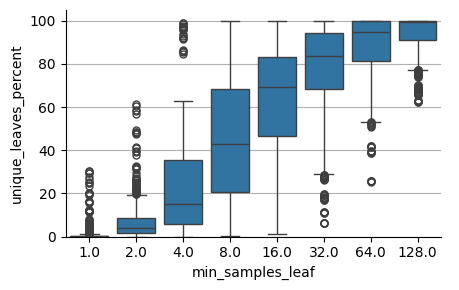

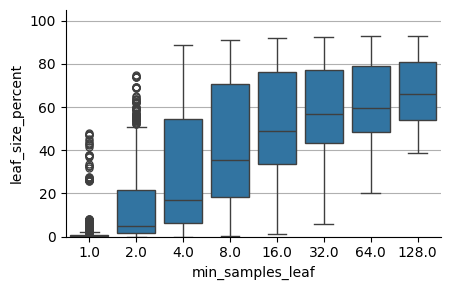

In [71]:
depth_limit = 'min_samples_leaf'
#depth_limit = 'max_depth'


def add_grid(g, **kwargs):
    for i, ax in enumerate(g.axes.flatten()):
        ax.grid(**kwargs)


sel = unoptimized[(unoptimized.strategy == 'original')]
unoptimized[(unoptimized.strategy == 'original') & (unoptimized.trees == 10)]

#fig, axs = plt.subplots(ncols=2)
height = 3.0
aspect = 1.5
g = seaborn.catplot(data=sel,
                x=depth_limit, kind='box', y='unique_leaves_percent', 
                height=height, aspect=aspect)
g.set(ylim=(0, 105))
add_grid(g, axis='y')
g.figure.tight_layout()
g.figure.savefig('leaf-uniqueness.png')

g = seaborn.catplot(data=sel,
                x=depth_limit, kind='box', y='leaf_size_percent', 
                height=height, aspect=aspect,)
g.set(ylim=(0, 105))
add_grid(g, axis='y')
g.figure.tight_layout()
g.figure.savefig('leaf-proportion.png')



In [72]:
reduced = unoptimized.copy()
reduced = reduced[~reduced.experiment.isin(['sklearn_defaults'])]
reduced.shape

(65280, 27)

In [74]:
reduced.columns

Index(['leaves_per_class', 'leaf_bits', 'split', 'test_nodes', 'test_leaves',
       'test_leafsize', 'test_uniqueleaves', 'test_roc_auc', 'dataset',
       'experiment', 'run', 'min_samples_leaf', 'trees', 'train_roc_auc',
       'n_estimators', 'dtype', 'target_max', 'folds', 'repetitions',
       'leaf_size', 'decision_size', 'total_size', 'leaf_size_percent',
       'unique_leaves_percent', 'strategy', 'perf_change', 'size_change'],
      dtype='object')

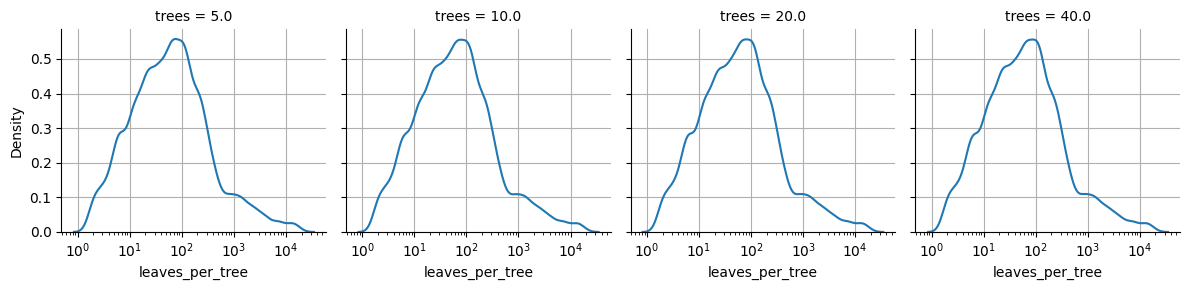

In [91]:
sel = reduced.reset_index()
sel[sel.trees == 10]
sel['leaves_per_tree'] = sel.test_leaves / sel.trees
g = seaborn.displot(data=sel, kind='kde', x='leaves_per_tree',
                col='trees', #col_wrap=4,
                height=3.0,
                log_scale=(True, False), common_norm=False,
                #stat='percent'
               )

for ax in g.axes.flatten():
    ax.grid()  

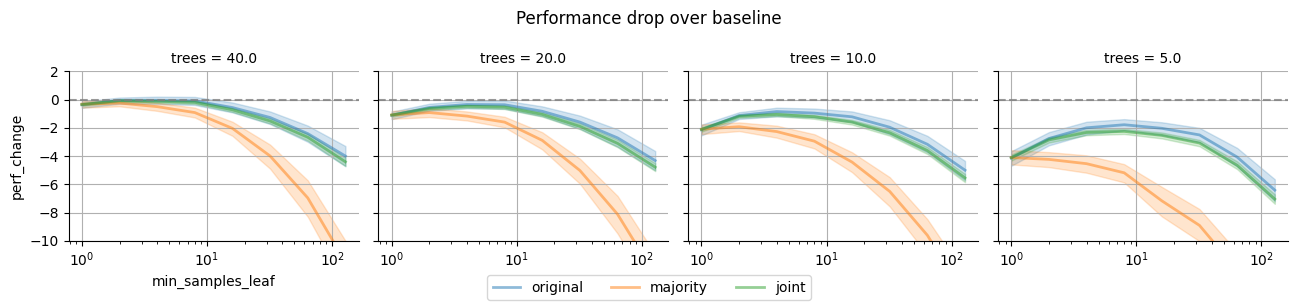

In [87]:

col_order = sorted(reduced.trees.unique(), reverse=True)
g = seaborn.relplot(data=reduced.reset_index(),
                    kind='line',
                    x=depth_limit,
                    y='perf_change',
                    hue='strategy',
                    col='trees',
                    col_order=col_order,
                    aspect=1, height=3,
                    legend=True,
                    #errorbar=None,
                    #err_style='bars',
                    lw=2.0,
                    alpha=0.5,
                   )
g.set(xscale="log")
#g.set(xlim=(1, 100))
g.set(ylim=(-10, 2))
g.refline(y=0.0, alpha=0.8, ls='--')
#g.refline(y=-2.0, alpha=0.5, color='black')
#g.refline(y=-4.0, alpha=0.5, color='orange')
for i, ax in enumerate(g.axes.flatten()):
    ax.grid()
    if i >= 1:
        x_axis = ax.axes.get_xaxis()
        x_axis.get_label().set_visible(False)


g.figure.suptitle('Performance drop over baseline')
g.figure.tight_layout()
g.figure.legends = []
g.figure.legend(loc="lower center", ncol=3)
g.figure.savefig('hyperparam-perfdrop-trees-strategies.png')


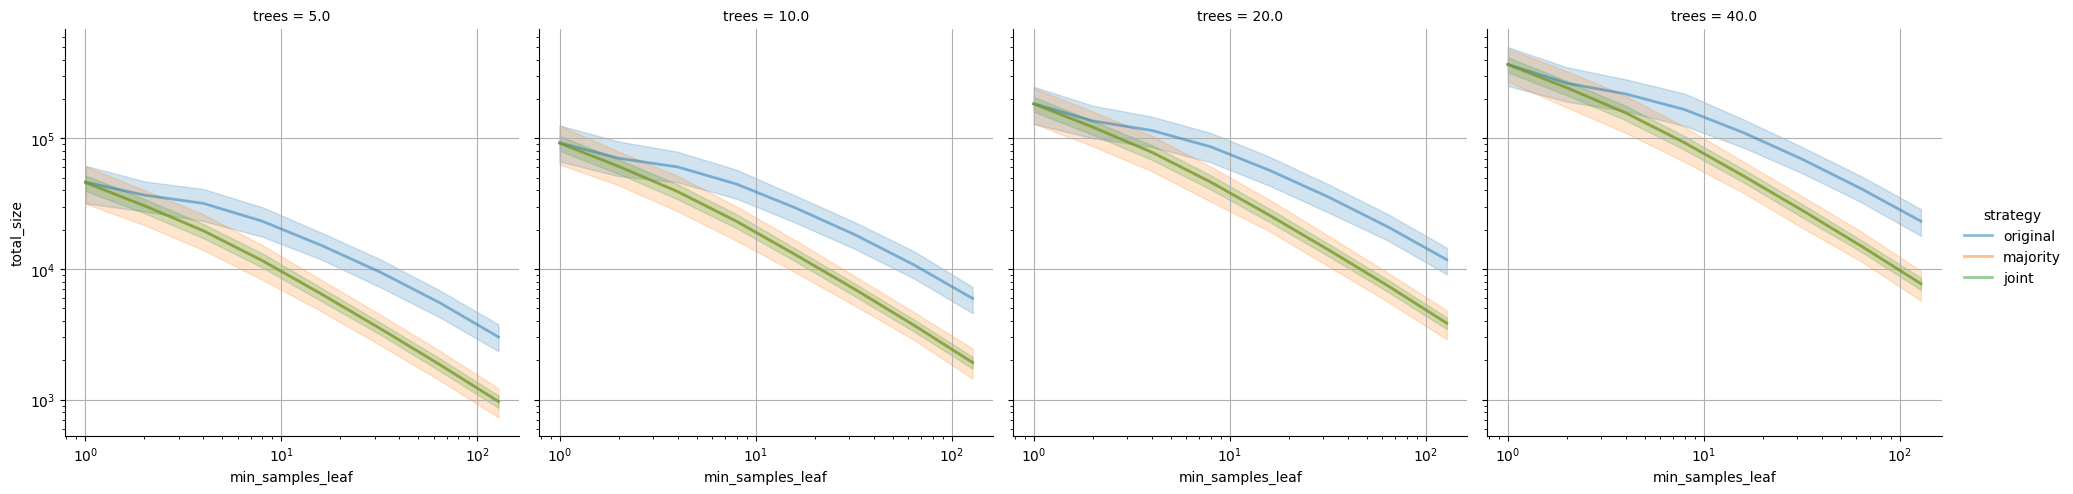

In [11]:
sel = reduced.reset_index()
#sel = sel[sel.leaf_bits == 8]
g = seaborn.relplot(data=sel,
                    kind='line',
                    x='min_samples_leaf',
                    y='total_size',
                    hue='strategy',
                    col='trees',
                    aspect=1.0, height=5,
                    legend=True,
                    #errorbar=None,
                    #err_style='bars',
                    lw=2.0,
                    alpha=0.5,
                   )
g.set(xscale="log", yscale='log')
for ax in g.axes.flatten():
    ax.grid()


In [77]:

import numpy

def aggregated_performance(df, agg='median'):
    folds = 5 
    repetitions = 1
    results_per_group = repetitions * folds

    groups = df.groupby(['dataset', 'strategy', 'min_samples_leaf', 'trees', 'leaves_per_class'], as_index=True, dropna=False)
    metrics = ['perf_change', 'total_size']

    # check that we got all the results / have specified the groups correctly
    for idx, g in groups:
        mismatch = len(g) != results_per_group
        if mismatch:
            print(idx, len(g))
            print(g['id'].nunique())
            print(g['run'].unique())
            print(g.head(30))
            raise ValueError('wrong numer of values per group')
            
    out = groups.agg(agg, numeric_only=True)[metrics]
    return out


sel = reduced.reset_index()
sel = aggregated_performance(sel)
sel = sel.sort_values('dataset', ascending=False)
g = seaborn.relplot(data=sel,
                    kind='scatter',
                    x='total_size',
                    y='perf_change',
                    hue='strategy',
                    col='dataset',
                    col_wrap=4,
                    aspect=3, height=4,
                    legend=True,
                    #lw=2.0,
                    s=20.0,
                    alpha=0.7,
                   )

g.figure.tight_layout()
g.figure.legends = []
g.figure.legend(loc="upper center", ncol=3)

g.set(xscale="log")
g.set(ylim=(-20, 10))
g.set(xlim=(100, 100e3))
g.refline(y=0.0, lw=2.0)
for ax in g.axes.flatten():
    ax.grid()  

ValueError: Could not interpret value `test_leaves` for `y`. An entry with this name does not appear in `data`.

/home/jon/projects/tiny-random-forests/venv/lib/python3.11/site-packages/seaborn/axisgrid.py:453: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=figsize)


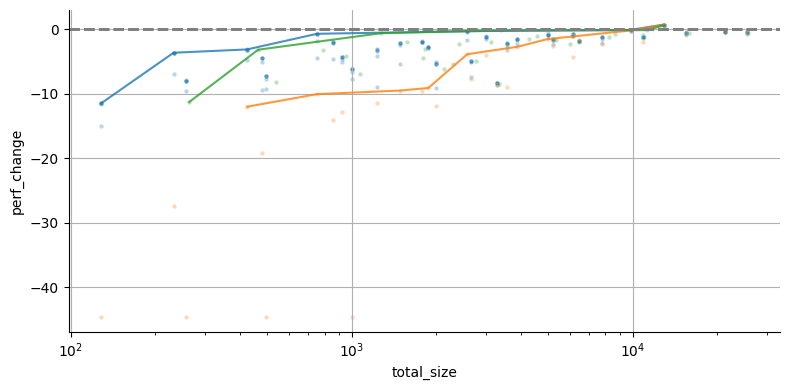

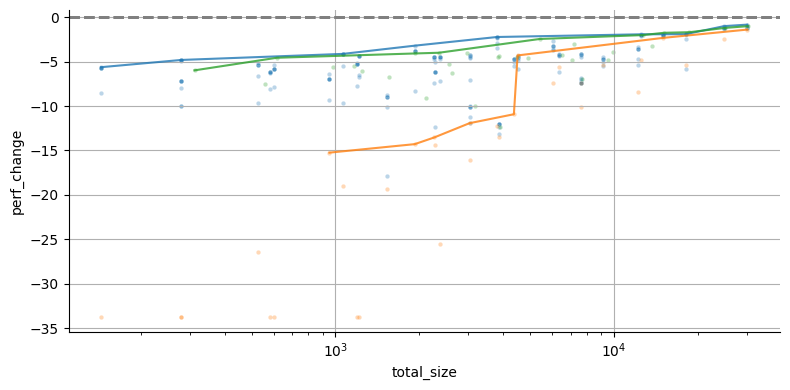

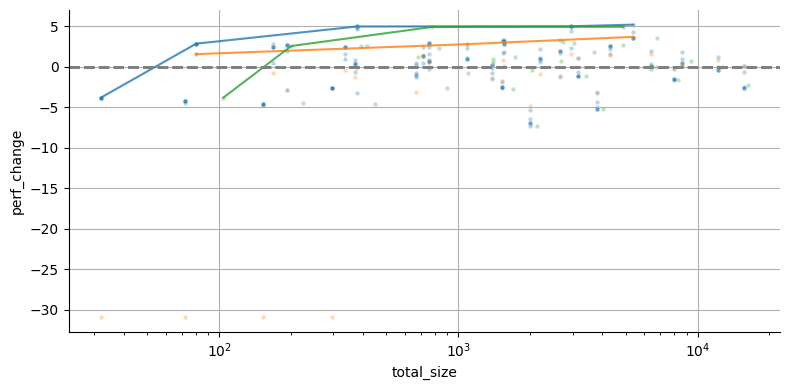

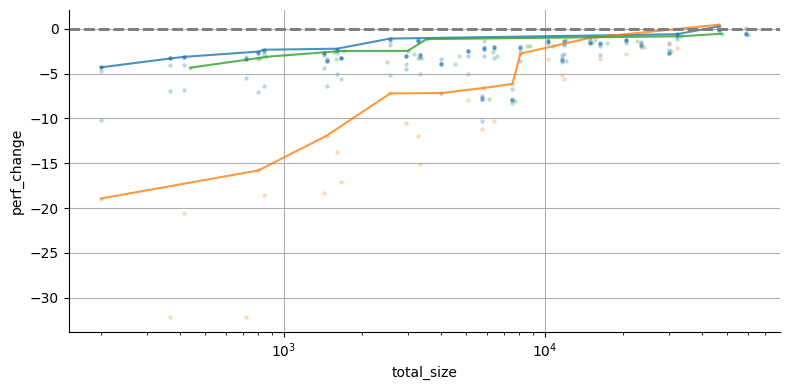

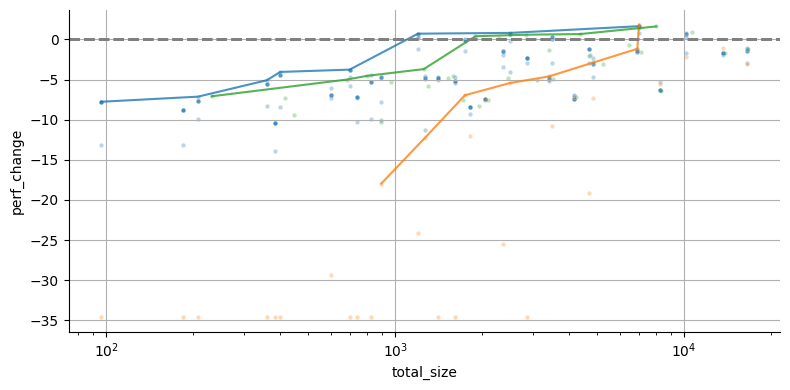

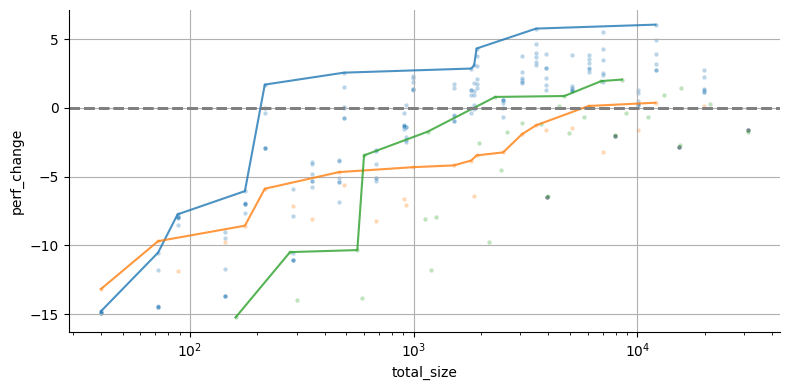

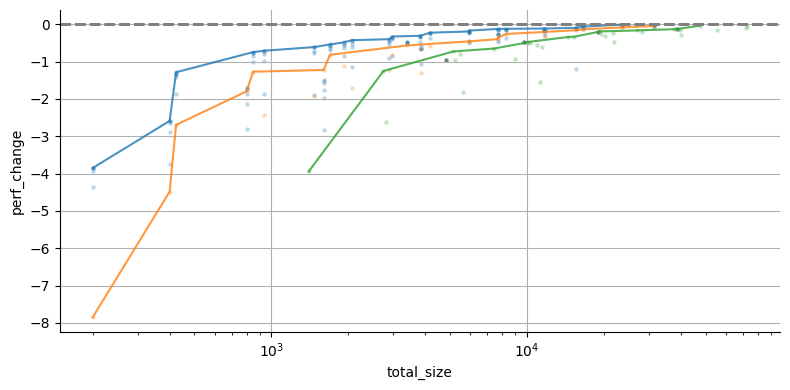

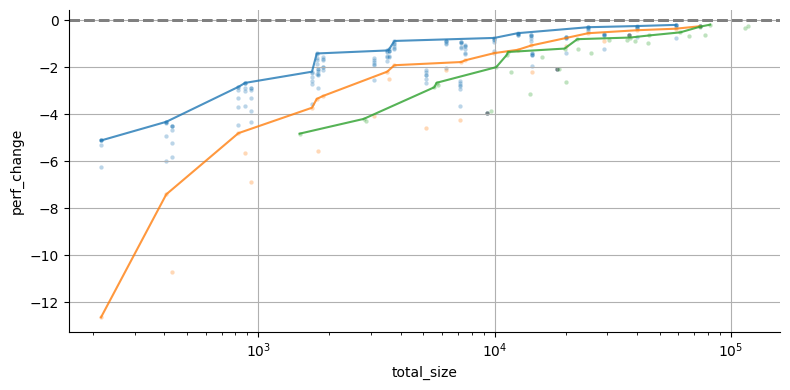

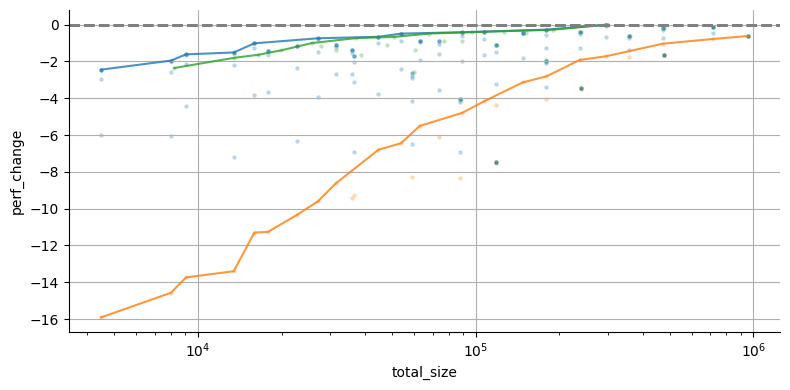

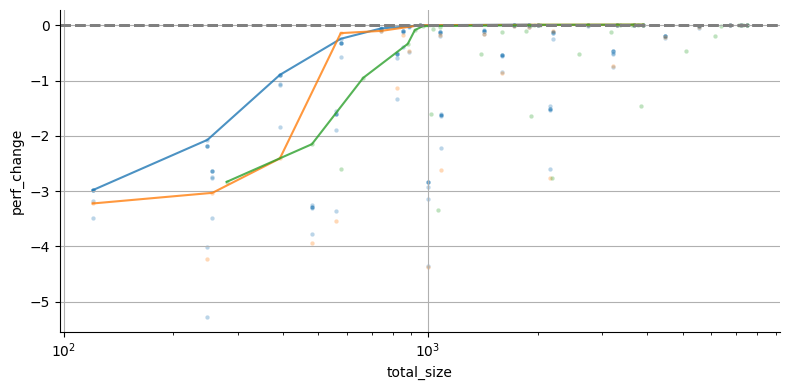

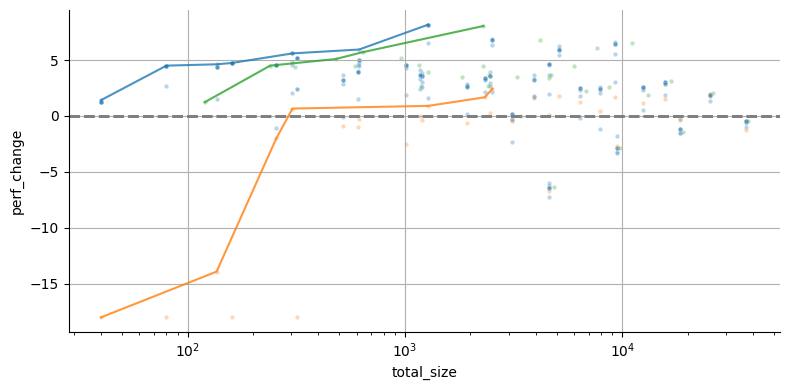

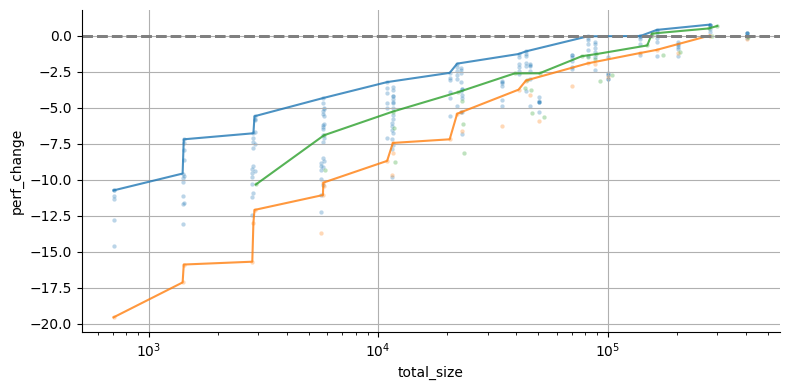

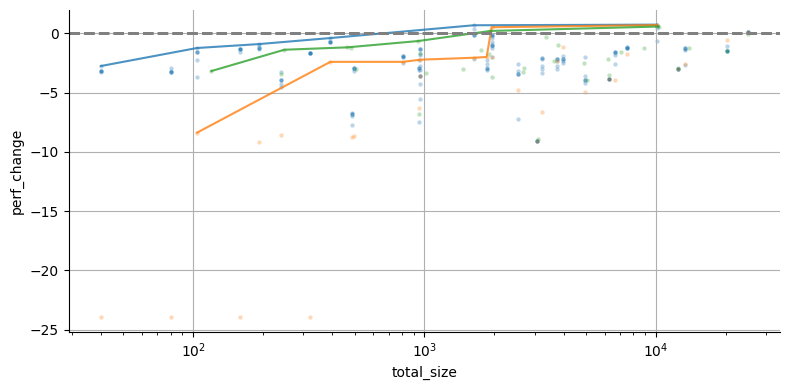

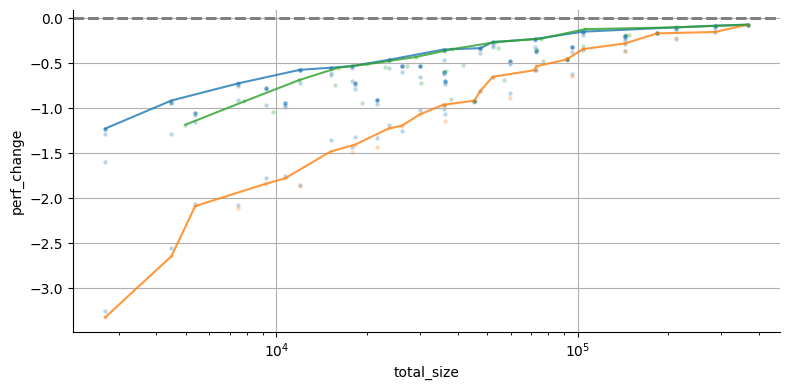

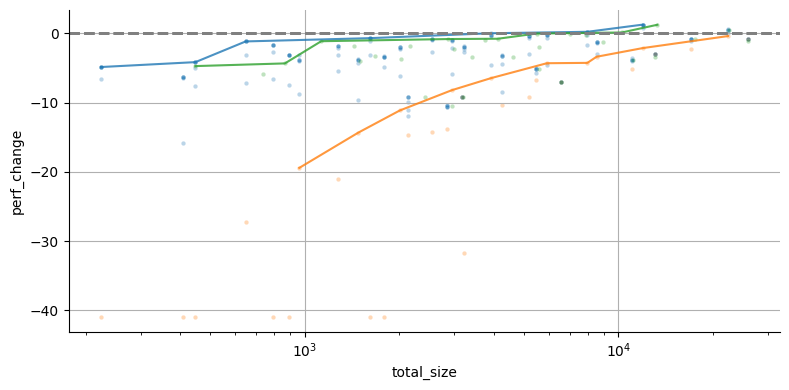

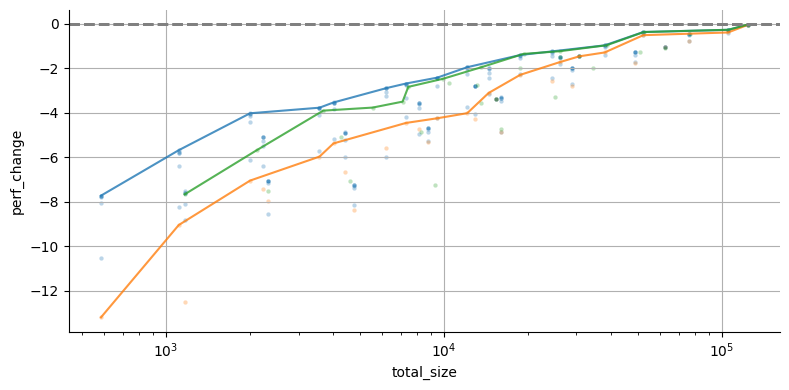

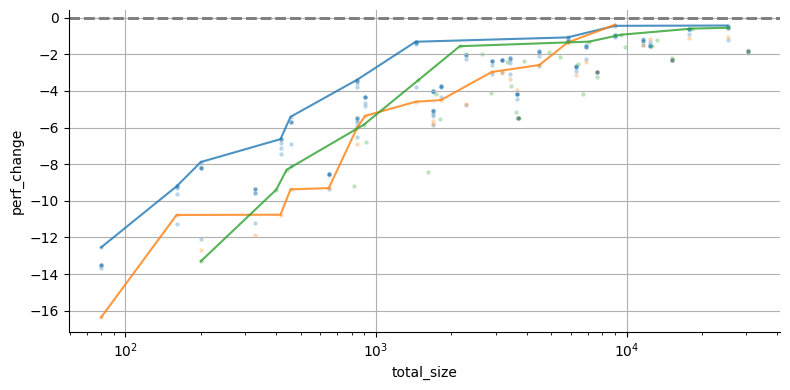

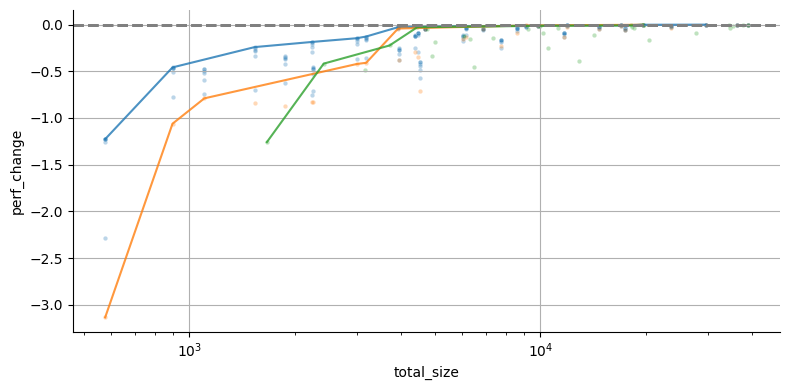

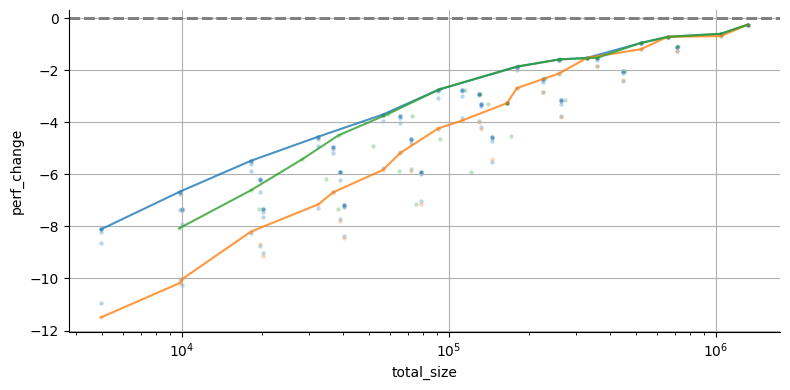

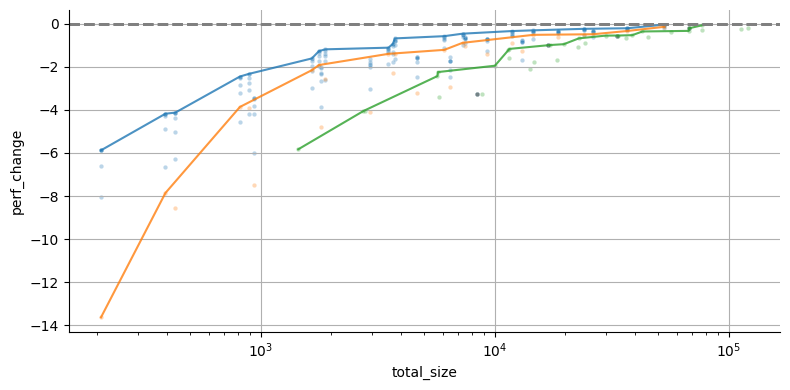

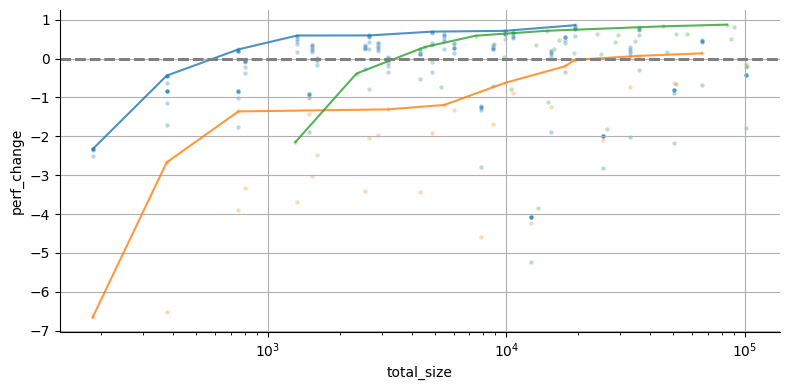

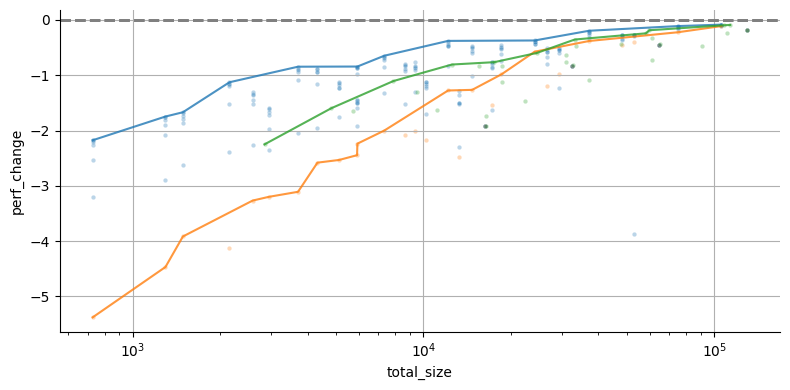

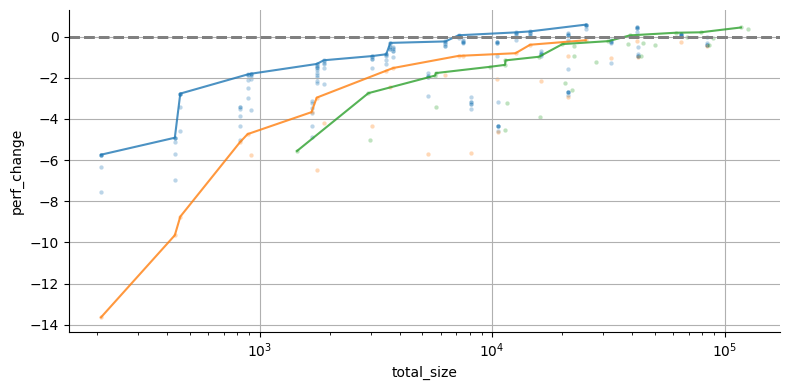

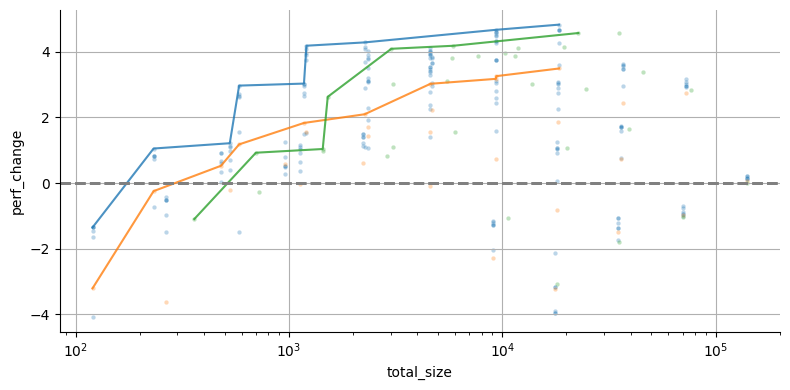

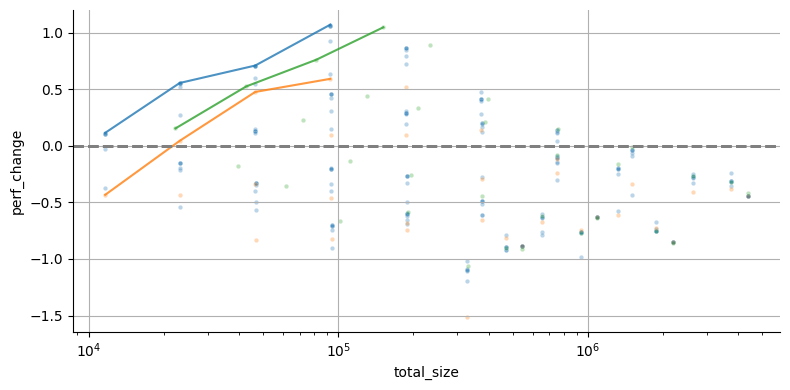

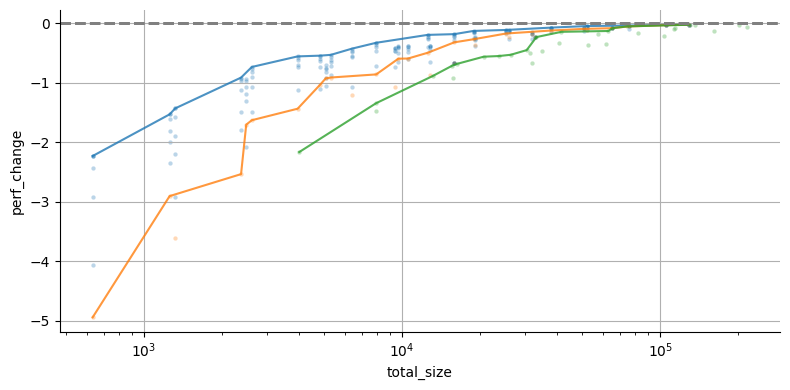

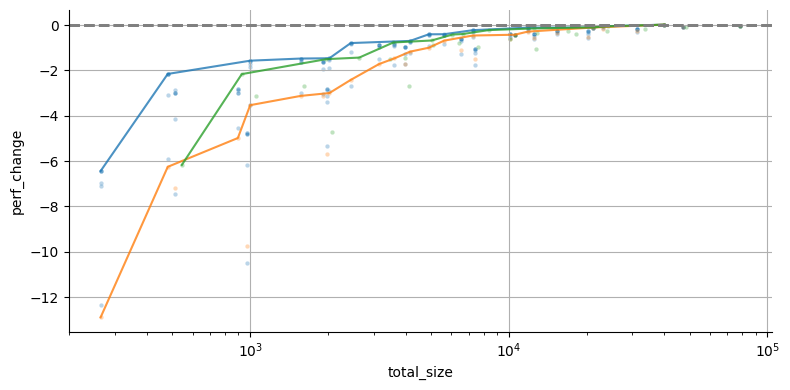

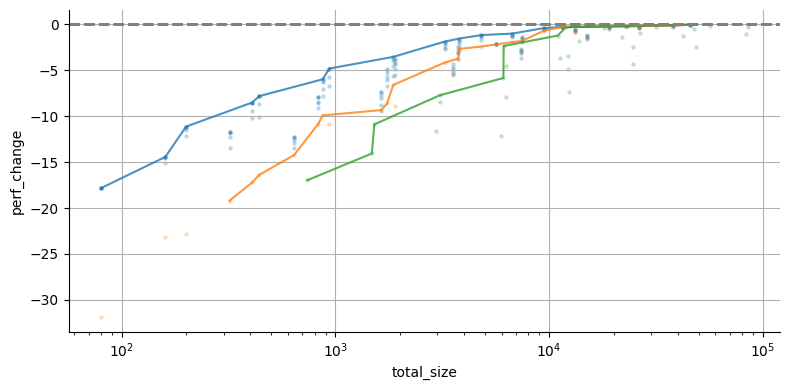

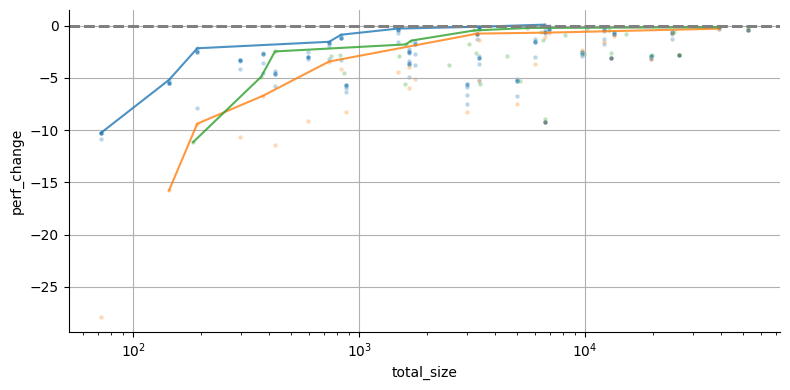

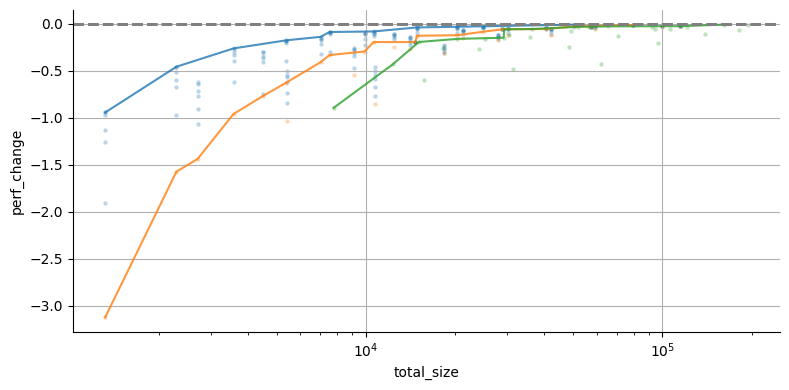

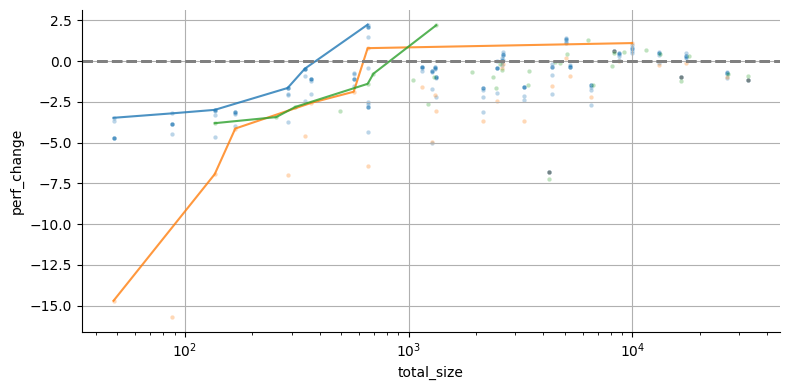

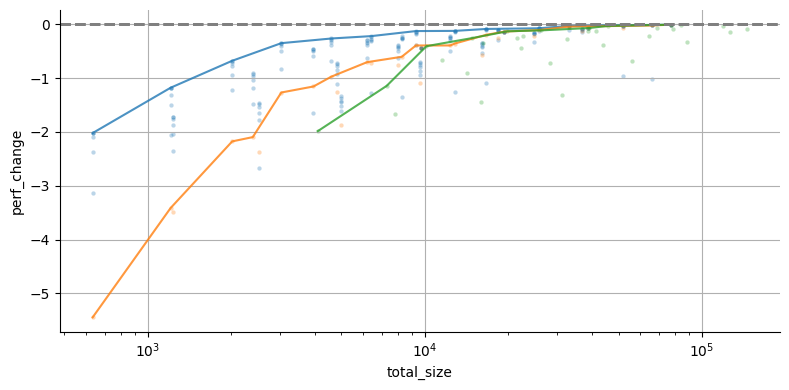

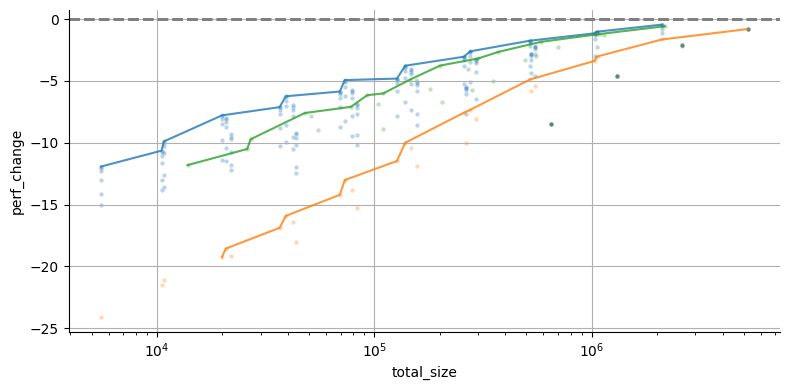

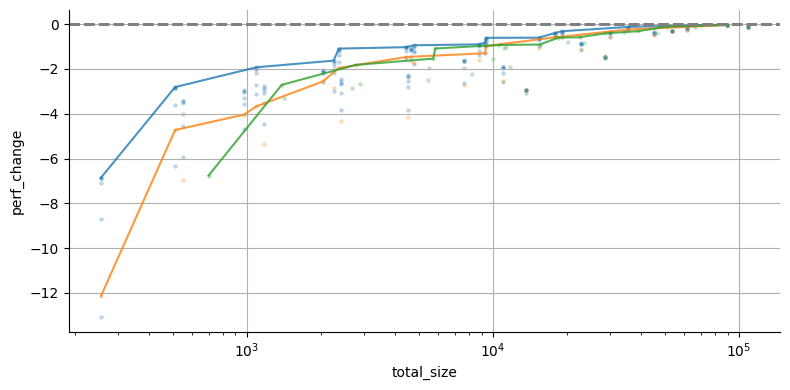

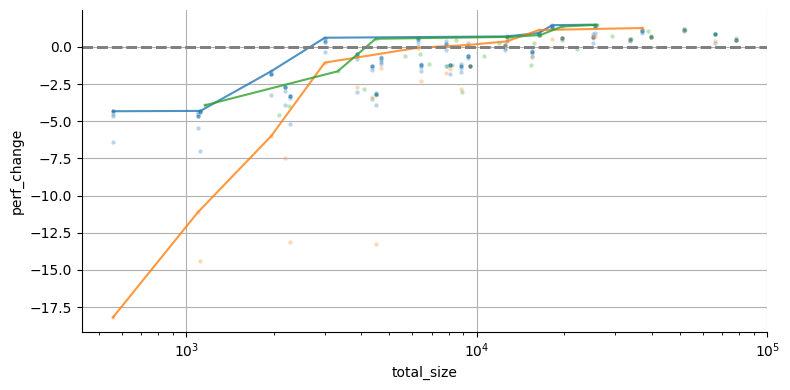

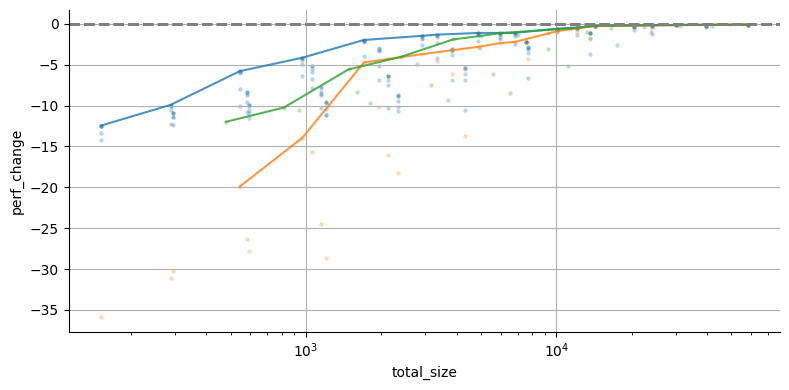

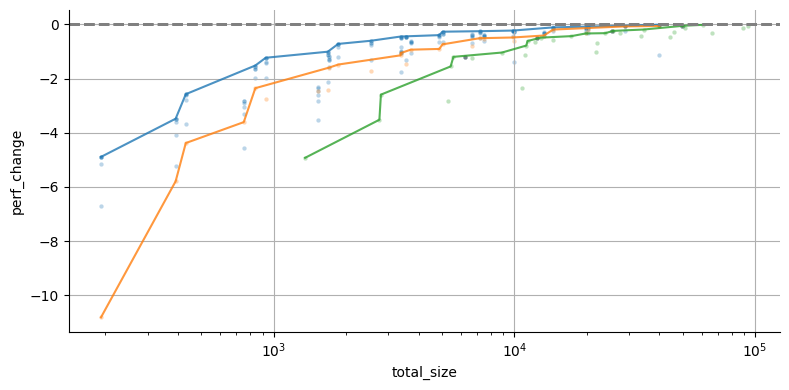

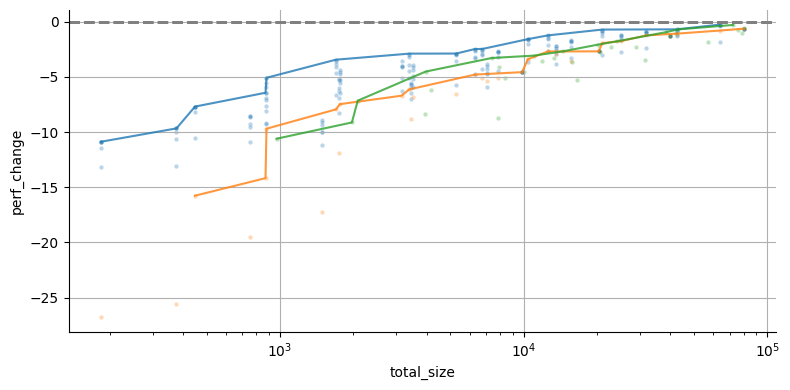

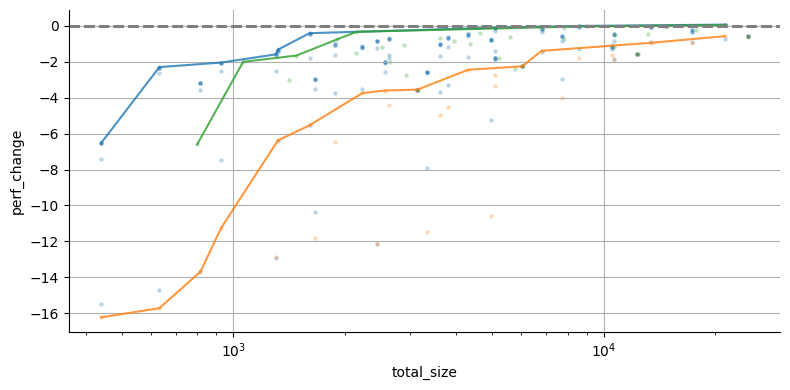

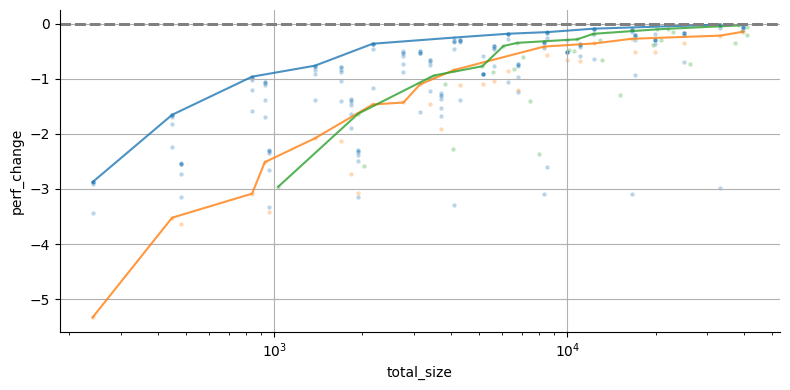

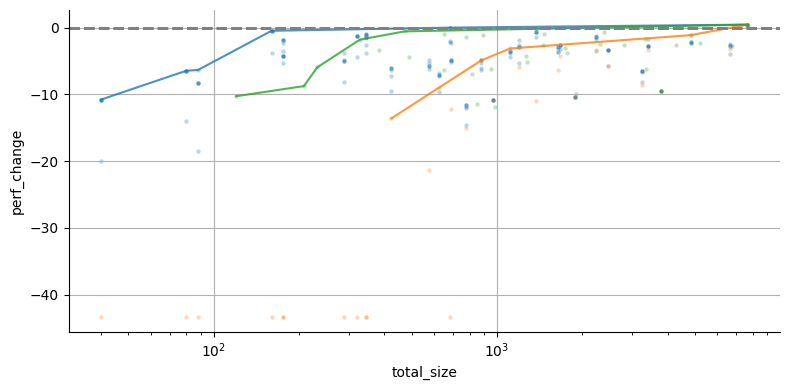

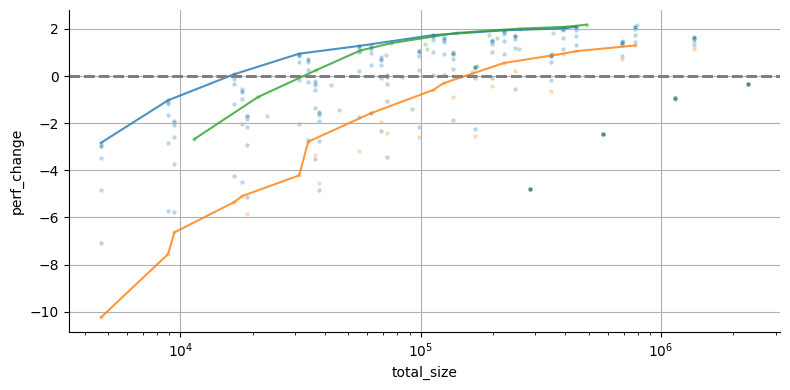

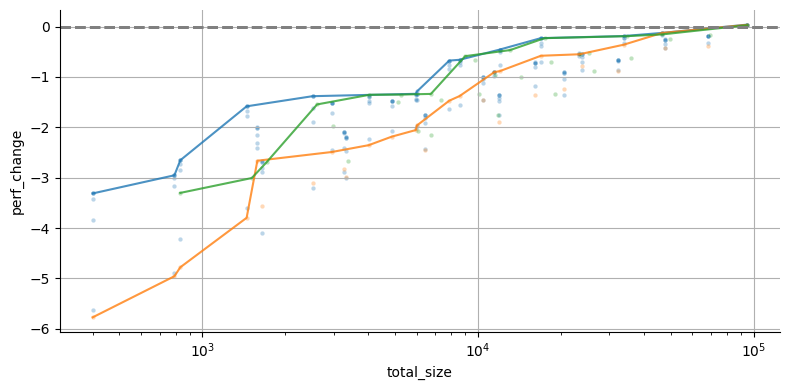

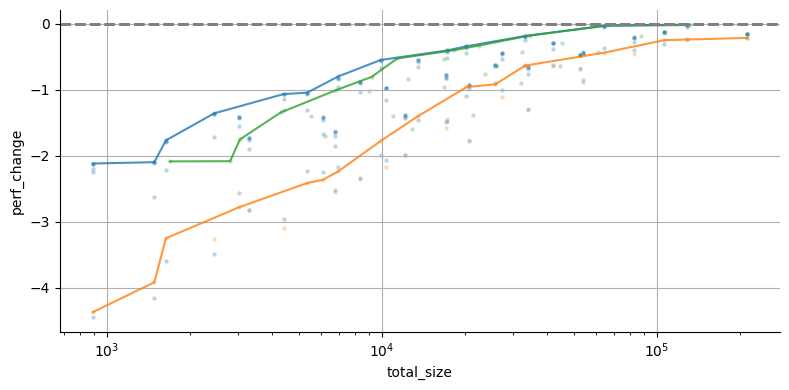

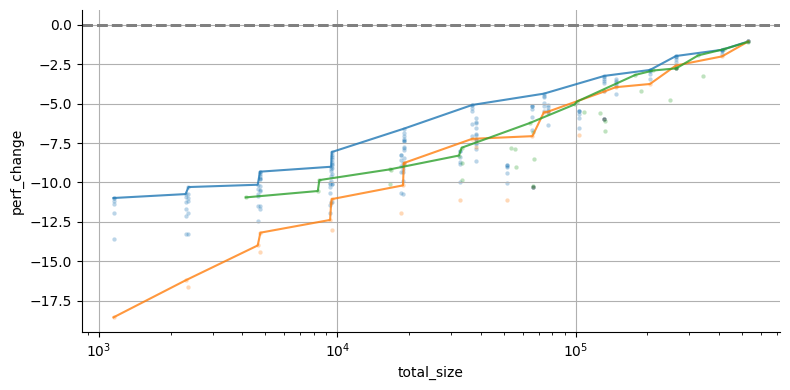

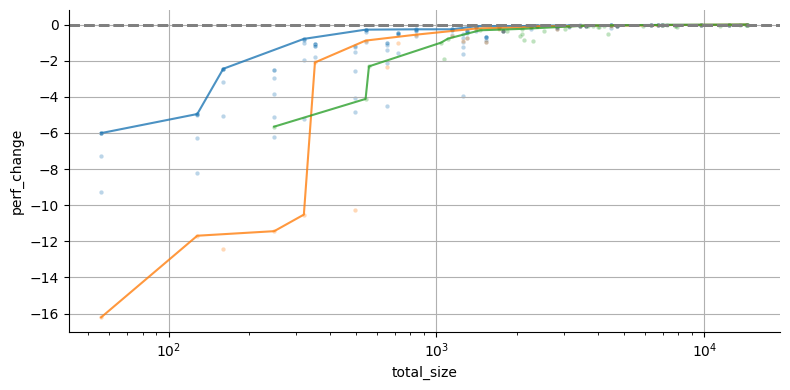

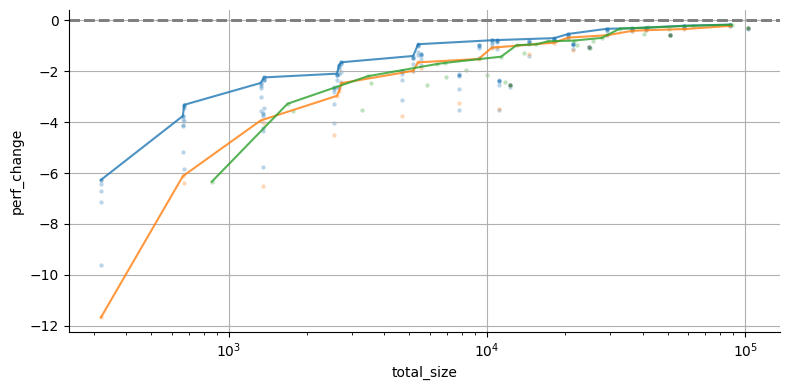

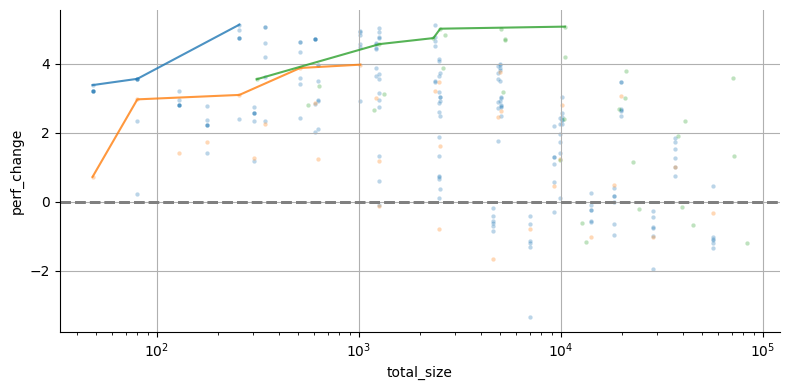

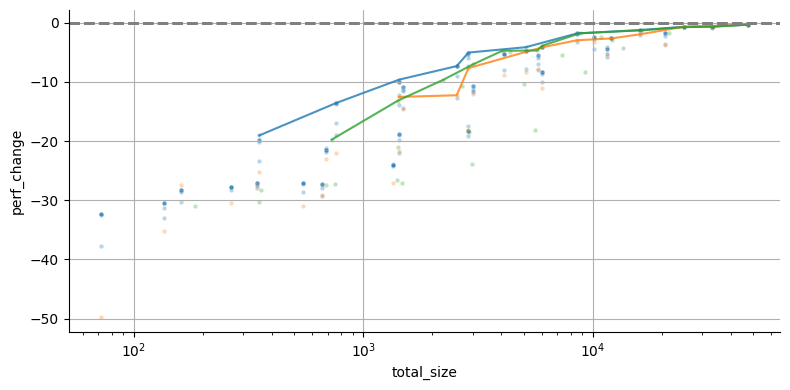

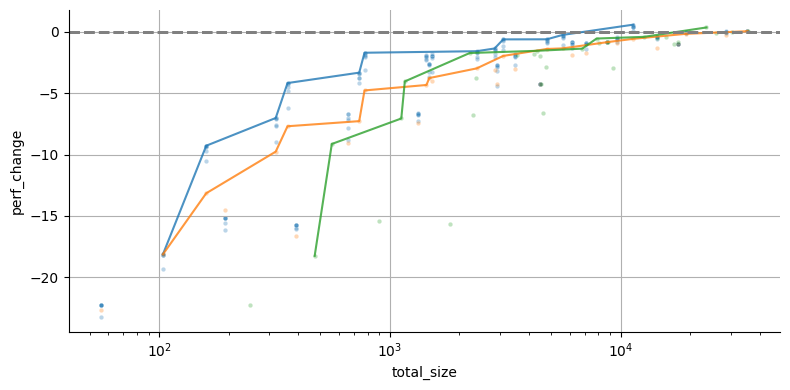

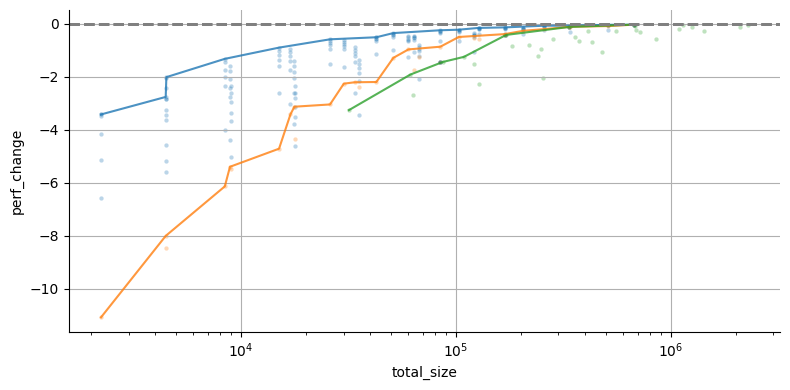

In [13]:

from src.utils.pareto import find_pareto_front, plot_pareto_front


sel = reduced.reset_index()
sel = aggregated_performance(sel)
sel = sel.sort_values('dataset', ascending=False)
#sel = sel.sort_values('dataset', ascending=False)

groups = sel.groupby('dataset')
for idx, g_df in groups:

    #print(g_df.columns)
    # FIXME: set hue_order ?
    g_df = g_df.sort_values('strategy').reset_index()
    g = plot_pareto_front(g_df,
                          hue='strategy',
                          cost_metric='total_size',
                          performance_metric='perf_change',
                          size_metric=None,
                          aspect=2,
                          height=4,
                          s=10.0,
                          pareto_s=10.0,
                          pareto_cut=-20,
                         )
    
    #g.figure.tight_layout()
    g.figure.legends = []
    #g.figure.legend(loc="upper center", ncol=3)
    
    g.set(xscale="log")
    #g.set(ylim=(-20, 10))
    #g.set(xlim=(100, 100e3))
    g.refline(y=0.0, lw=2.0)
    for ax in g.axes.flatten():
        ax.grid()

    #break # TEMP
    


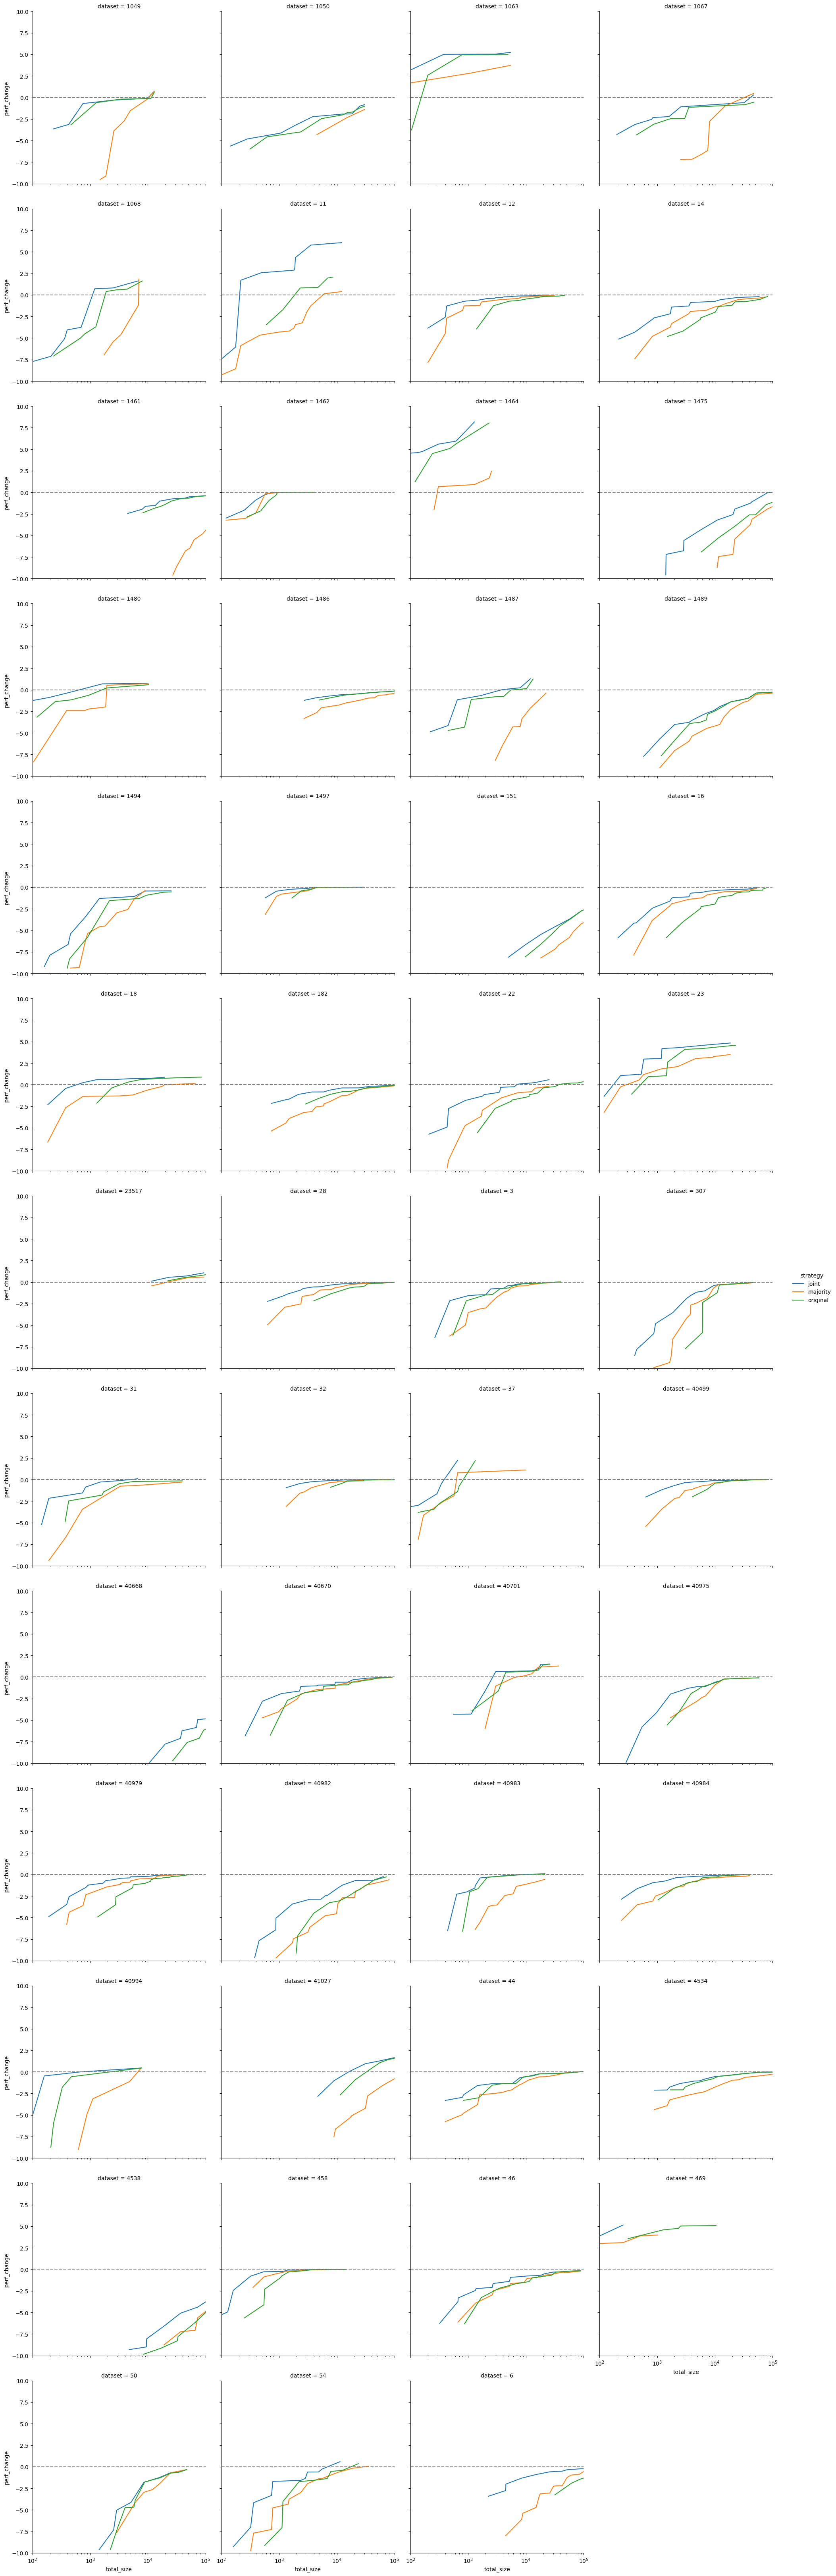

In [14]:

sel = reduced.reset_index()
sel = aggregated_performance(sel)
sel = sel.sort_values('dataset', ascending=False)
#sel = sel.sort_values('dataset', ascending=False)

def find_pareto(df, cost_metric='total_size', performance_metric='perf_change',  min_performance=-10.0):

    pareto_params = dict(
        cost_metric=cost_metric,
        performance_metric=performance_metric,
        min_performance=min_performance,
    )
    
    pf = find_pareto_front(df, **pareto_params)
    pf['point'] = numpy.arange(len(pf))
    pf = pf.set_index('point')
    #print(len(pf))
    return pf

pareto = sel.groupby(['dataset', 'strategy'], as_index=True).apply(find_pareto)

g = seaborn.relplot(data=pareto.reset_index(),
                kind='line',
                col='dataset', col_wrap=4,
                y='perf_change',
                x='total_size',
                hue='strategy'
               )
g.set(xscale="log")
g.set(ylim=(-10, 10))
g.set(xlim=(100, 100e3))
g.refline(y=0.0)


In [15]:

def find_differences(pareto, groups='strategy', ref='joint'):

    p = pareto.set_index(groups)
    ref_values = p.loc[ref]

    other = pandas.concat([p.loc['majority'], p.loc['original']], ignore_index=True)

    cost_metric = 'total_size'
    performance_metric = 'perf_change'

    records = []
    for _, row in ref_values.iterrows():
        ref_performance = row[performance_metric]
        ref_cost = row[cost_metric]
        
        sub = other[other[performance_metric] >= ref_performance]
        alt_cost = sub[cost_metric].min()

        rel = alt_cost / ref_cost 
        
        records.append({'point': row.point, 'gain': rel})

    out = pandas.DataFrame.from_records(records).set_index('point')
    return out

    #print(ref_values)
    #print(other)

gains = pareto.reset_index().groupby('dataset', as_index=True).apply(find_differences)
gains

/tmp/ipykernel_32216/3741656000.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gains = pareto.reset_index().groupby('dataset', as_index=True).apply(find_differences)


gain
dataset point           
1049    0       1.309194
        1       1.322981
        2       3.000000
        3       1.691489
        4            NaN
...                  ...
6       11      2.613279
        12      2.624301
        13     11.373665
        14      6.740143
        15      7.612903

[570 rows x 1 columns]

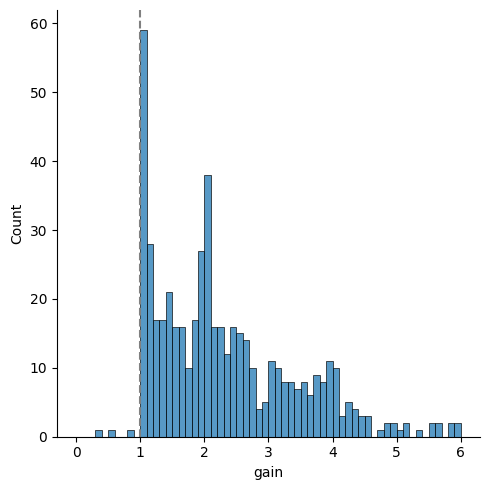

In [16]:
g = seaborn.displot(data=gains.reset_index(), x='gain', binrange=(0,6), binwidth=0.10)
g.refline(x=1.0)

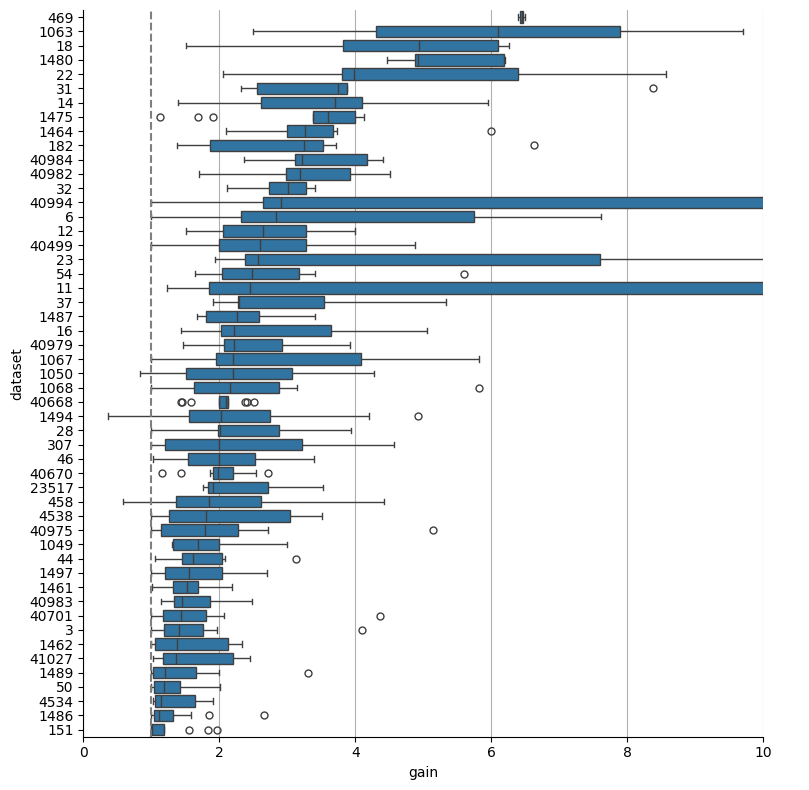

In [17]:
order = gains.groupby('dataset').median()['gain'].sort_values(ascending=False)
#print(order)
g = seaborn.catplot(data=gains.reset_index(),
                    kind='box',
                    x='gain',
                    aspect=1,
                    height=8.0,
                    y='dataset',
                    order=order.index)
for ax in g.axes.flatten():
    ax.grid(axis='x')
g.set(xlim=(0, 10))
g.refline(x=1.0)

In [54]:
dataset_classes = data.groupby('dataset')['test_leafsize'].median().rename('n_classes')
gains = pandas.merge(gains.reset_index(), dataset_classes, left_on='dataset', right_index=True)
gains

,index,dataset,point,gain,test_leafsize,n_classes
0,0,1049,0,1.309194,2.0,2.0
1,1,1049,1,1.322981,2.0,2.0
2,2,1049,2,3.000000,2.0,2.0
3,3,1049,3,1.691489,2.0,2.0
4,4,1049,4,NaN,2.0,2.0
...,...,...,...,...,...,...
565,565,6,11,2.613279,26.0,26.0
566,566,6,12,2.624301,26.0,26.0
567,567,6,13,11.373665,26.0,26.0
568,568,6,14,6.740143,26.0,26.0


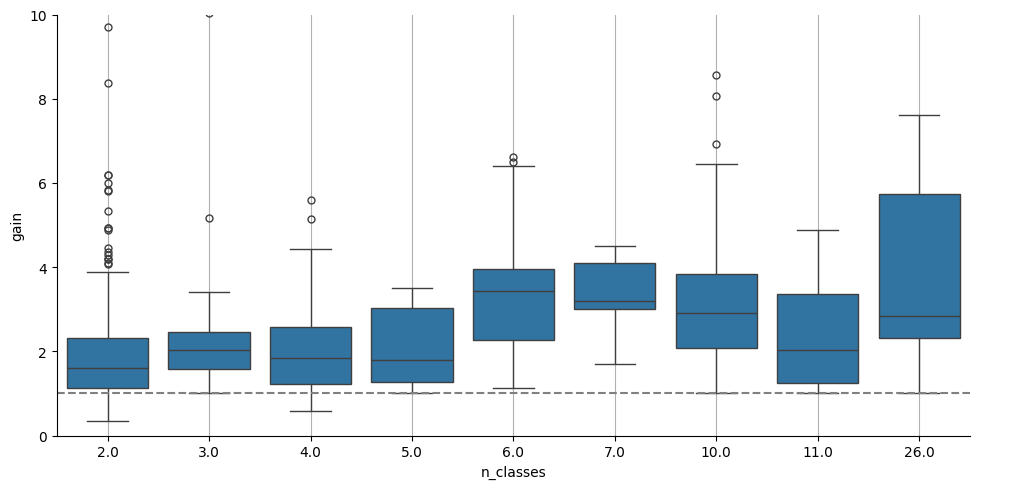

In [65]:

order = gains.groupby('dataset').median()['gain'].sort_values(ascending=False)
#print(order)
g = seaborn.catplot(data=gains.reset_index(),
                    kind='box',
                    y='gain',
                    x='n_classes',
                    #hue='dataset',
                    aspect=2,
                    height=5.0,
                )
for ax in g.axes.flatten():
    ax.grid(axis='x')
g.set(ylim=(0, 10))
g.refline(y=1.0)


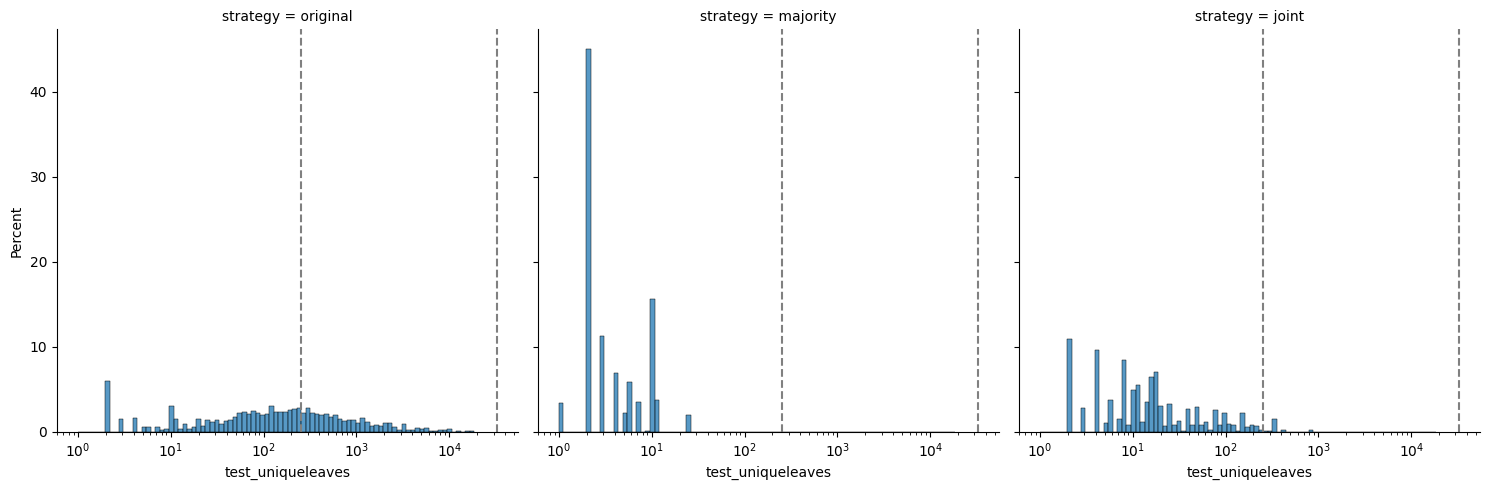

In [34]:
g = seaborn.displot(data=unoptimized, kind='hist', x='test_uniqueleaves', col='strategy', height=5, log_scale=(True, False), common_norm=False, stat='percent')
#g.set(xscale='log')
g.refline(x=2**8)
g.refline(x=2**15)

In [38]:
unoptimized.columns

Index(['leaves_per_class', 'leaf_bits', 'split', 'test_nodes', 'test_leaves',
       'test_leafsize', 'test_uniqueleaves', 'test_roc_auc', 'dataset',
       'experiment', 'run', 'min_samples_leaf', 'trees', 'train_roc_auc',
       'n_estimators', 'dtype', 'target_max', 'folds', 'repetitions',
       'leaf_size', 'decision_size', 'total_size', 'leaf_size_percent',
       'unique_leaves_percent', 'strategy', 'perf_change', 'size_change'],
      dtype='object')

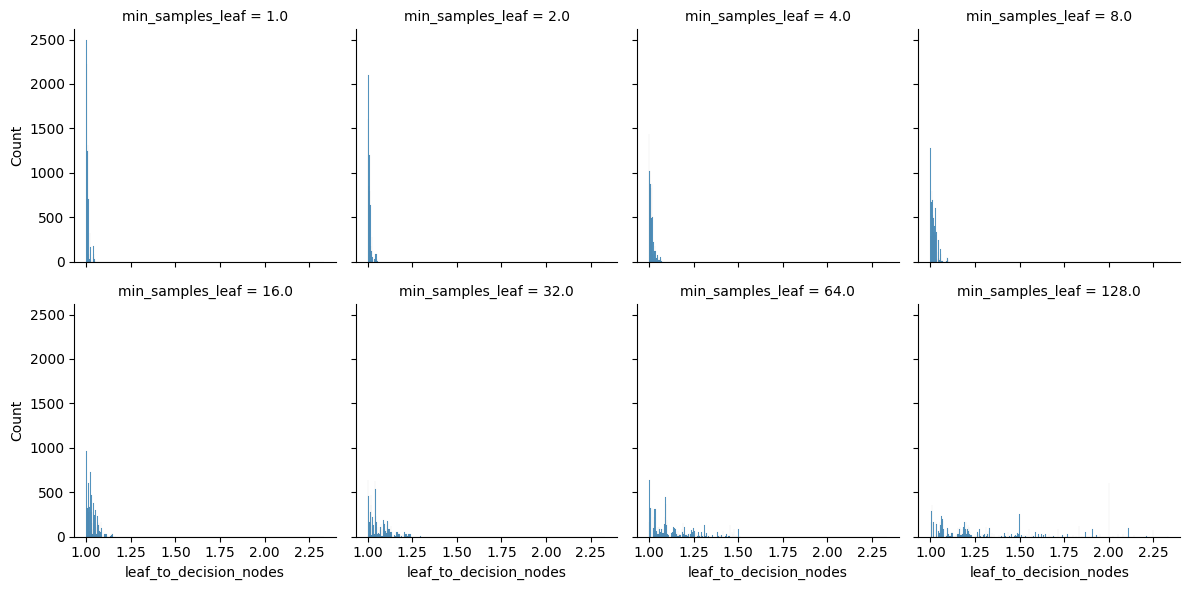

In [47]:
sel = unoptimized.copy()
sel['leaf_percentage'] = 100 * (sel.test_leaves / sel.test_nodes)
sel['leaf_to_decision_nodes'] = sel.test_leaves / (sel.test_nodes - sel.test_leaves)
seaborn.displot(sel, kind='hist', x='leaf_to_decision_nodes', col='min_samples_leaf', col_wrap=4, height=3.0)